# Unit Checked Arithmetic via SIUnits

Units and dimensional analysis are standard tools across the sciences for checking the correctness of your equation. However, most ODE solvers only allow for the equation to be in dimensionless form, leaving it up to the user to both convert the equation to a dimensionless form, punch in the equations, and hopefully not make an error along the way.

DifferentialEquations.jl allows for one to use Unitful.jl to have unit-checked arithmetic natively in the solvers. Given the dispatch implementation of the Unitful, this has little overhead.

## Using Unitful

To use SIUnits, you need to have the package installed. Then you can add units to your variables. For example:

In [2]:
using Unitful
t = 1.0u"s"

1.0 s

Notice that `t` is a variable with units in seconds. If we make another value with seconds, they can add

In [16]:
t2 = 1.02u"s"
t+t2

2.02 s

and they can multiply:

In [5]:
t*t2

1.02 s^2

You can even do rational roots:

In [6]:
sqrt(t)

1.0 s^1/2

Many operations work.

These operations will check to make sure units are correct, and will throw an error for incorrect operations:

In [7]:
t + sqrt(t)

LoadError: LoadError: Unitful.DimensionError()
while loading In[7], in expression starting on line 1

## Using SIUnits with DifferentialEquations.jl

Just like with other number systems, you can choose the units for your numbers by simply specifying the units of the initial condition and the timestep. For example, to solve the linear ODE where the variable has units of Newton's and `t` is in Seconds, we would use:

In [4]:
using DifferentialEquations
f = (t,y) -> 0.5*y
u₀ = 1.5u"N"
prob = ODEProblem(f,u₀)

sol =solve(prob::ODEProblem,[0,1],Δt=(1/2^4)u"s",save_timeseries=true,alg=:Midpoint)

LoadError: LoadError: Unitful.DimensionError()
while loading In[4], in expression starting on line 6

Notice that we recieved a unit mismatch error. This is correctly so! Remember that for an ODE:

$$ \frac{dy}{dt} = f(t,y) $$

we must have that `f` is a rate, i.e. `f` is a change in `y` per unit time. So we need to fix the units of `f` in our example to be `N/s`. Notice that we then do not receive an error if we do the following:

In [6]:
f = (t,y) -> 0.5*y/3.0u"s"
prob = ODEProblem(f,u₀)

sol =solve(prob::ODEProblem,[0,1],Δt=(1/2^4)u"s",save_timeseries=true,alg=:Midpoint)

DifferentialEquations.ODESolution, 17 timesteps, final value 1.7720353197843262 N

This gives a a normal solution object. Notice that the values are all with the correct units:

In [12]:
print(sol.timeseries)

Unitful.Quantity{Float64,Unitful.Dimensions{(Unitful.Dimension{:Length}(1//1),Unitful.Dimension{:Mass}(1//1),Unitful.Dimension{:Time}(-2//1))},Unitful.Units{(Unitful.Unit{:Newton}(0,1//1),),Unitful.Dimensions{(Unitful.Dimension{:Length}(1//1),Unitful.Dimension{:Mass}(1//1),Unitful.Dimension{:Time}(-2//1))}}}[1.5 N,1.51571 N,1.53158 N,1.54761 N,1.56382 N,1.58019 N,1.59674 N,1.61346 N,1.63035 N,1.64742 N,1.66467 N,1.68211 N,1.69972 N,1.71752 N,1.7355 N,1.75367 N,1.77204 N]

We can plot the solution using the plot recipe.


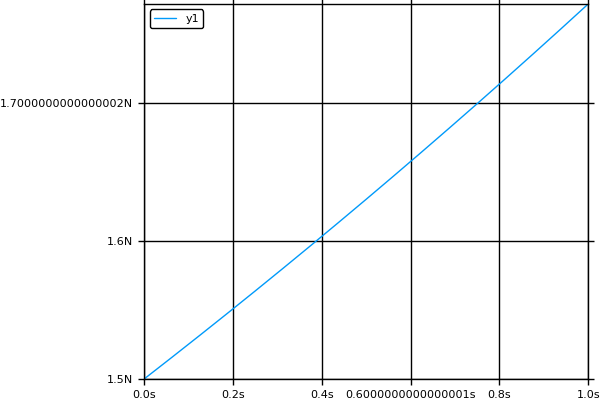

In [13]:
using UnitfulPlots
plot(sol.t,sol[:])

Notice that here we pulled the units for the label directly from the solution. Thus if the units change, the labels will change automatically.

## Other Solvers and Future Developments

As of right now, the ODE solvers are the only solvers which are fully compatible with units. The SDE solvers will come shortly. For the FEM PDE solvers, the tooling is all compatible with units (i.e. you can make meshes with units, and most of the functions will work). However, the solver step is what's not compatible with units. The reason is because `\` uses CHOLMOD which does not work with units, and sparse multiplication also is undefined for units. These facts are major stop gaps in development here. I believe it's not worth it to simply "turn off" units at that point because that is there area where one would wish to have units checked.